<a href="https://colab.research.google.com/github/EllieMwangi/NaiveBayes-KNN-Classification/blob/main/Titanic_Survival_Prediction_with_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Survival Prediction

### Specifying Analysis Question




Using data from the titanic shipwreck, build a model that predicts whether a passenger survived or not. 

### Defining the Metrics of Success

### Understanding the context


The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this notebook, I seek to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### Recording the Experimental Design





- Load Data
- Data Cleaning
- Exploratory Data Analysis
- Data Modelling
- Model Evaluation
- Model improvement and tuning
- Conclusion
- Challenging the solution

## Data Loading

In [244]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Set global parameters
%matplotlib inline
sns.set()
plt.rcParams['figure.figsize'] = (10.0, 8.0)
warnings.filterwarnings('ignore')

In [197]:
# Load data
titanicdt = pd.read_csv('titanic_data.csv')

In [198]:
# Preview data
titanicdt.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [199]:
titanicdt.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [200]:
# Shape of dataset
titanicdt.shape

(891, 12)

In [201]:
# Information about the dataset
titanicdt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [202]:
# Check for missing values
titanicdt.isnull().sum().sort_values(ascending=False)/titanicdt.shape[0] * 100

Cabin          77.104377
Age            19.865320
Embarked        0.224467
Fare            0.000000
Ticket          0.000000
Parch           0.000000
SibSp           0.000000
Sex             0.000000
Name            0.000000
Pclass          0.000000
Survived        0.000000
PassengerId     0.000000
dtype: float64

The cabin, age and embarked columns have the largest percentages of missing values.

In [203]:
# Check for duplicates
titanicdt.duplicated().any()

False

In [204]:
# Check for unique values in each column
columns = ['Survived', 'Pclass','Sex', 'Age', 'SibSp','Parch', 'Embarked']

for col in columns:
  print(f'Column: {col} \n')
  print(f'Number of unique values: {titanicdt[col].nunique()}\n')
  print(f'Unique values: {titanicdt[col].unique()}\n')



Column: Survived 

Number of unique values: 2

Unique values: [0 1]

Column: Pclass 

Number of unique values: 3

Unique values: [3 1 2]

Column: Sex 

Number of unique values: 2

Unique values: ['male' 'female']

Column: Age 

Number of unique values: 88

Unique values: [22.   38.   26.   35.     nan 54.    2.   27.   14.    4.   58.   20.
 39.   55.   31.   34.   15.   28.    8.   19.   40.   66.   42.   21.
 18.    3.    7.   49.   29.   65.   28.5   5.   11.   45.   17.   32.
 16.   25.    0.83 30.   33.   23.   24.   46.   59.   71.   37.   47.
 14.5  70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.
 56.   50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.
 60.   10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.
  0.67 30.5   0.42 34.5  74.  ]

Column: SibSp 

Number of unique values: 7

Unique values: [1 0 3 4 2 5 8]

Column: Parch 

Number of unique values: 7

Unique values: [0 1 2 5 3 4 6]

Column: Embarked 

Number of unique values: 3


## Data Cleaning

In [205]:
'''
Drop columns that aren't useful in our analysis:
- PassengerId: Acts a unique identifier for each passenger and thus does not provide information about the passenger
- Name: Similar to the passenger id
- Ticket: Similar to passenger id and name
- Cabin: Has 77% missing values
'''
to_drop = ['PassengerId', 'Name', 'Ticket','Cabin']
titanicdt.drop(to_drop, axis=1, inplace=True)

In [206]:
# Handle missing values in age and embarked columns
# For age column determine best measure of central tendecy: mean or median
titanicdt.Age.skew()

0.38910778230082704

Text(0.5, 1.0, 'Passenger Age distribution')

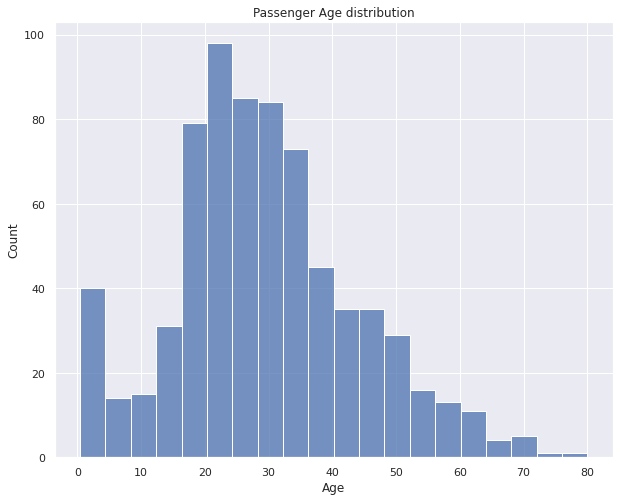

In [207]:
sns.histplot(titanicdt.Age)
plt.title('Passenger Age distribution')

Age column is relatively normally distributed therefore age is an adequate central tendency measure.

In [208]:
# dictionary of what to fill null values with
to_fill = {'Age':titanicdt.Age.mean(), 'Embarked': titanicdt.Embarked.mode()[0]}

titanicdt.fillna(to_fill, inplace=True)

In [209]:
# Checking for Outliers
features = titanicdt.drop('Survived', axis=1)

Q1 = features.quantile(0.25)
Q3 = features.quantile(0.75)
IQR = Q3 - Q1

# Get percentage of outliers per column:
for column, q1, q3,iqr in zip(Q1.index, Q1, Q3, IQR):
  outliers = features[((features[column] < q1 - 1.5 * iqr) | (features[column] > q3 + 1.5 * iqr))]
  outlier_percentage = outliers.shape[0] / features.shape[0] * 100
  print(f'Column: {column} \n')
  print(f'Outlier %: {outlier_percentage: .2f} \n')

Column: Pclass 

Outlier %:  0.00 

Column: Age 

Outlier %:  7.41 

Column: SibSp 

Outlier %:  5.16 

Column: Parch 

Outlier %:  23.91 

Column: Fare 

Outlier %:  13.02 



The parent/children column has the highest number of outliers with 23.91% of the column containing outliers.  Followed by the fare and age columns.

In [210]:
# Investigate the Parch column
titanicdt.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

Despite most passengers having 0 or 1 parents/children on board, having 3, 4, 5 or 6 children/parents on board is perfectly reasonable.

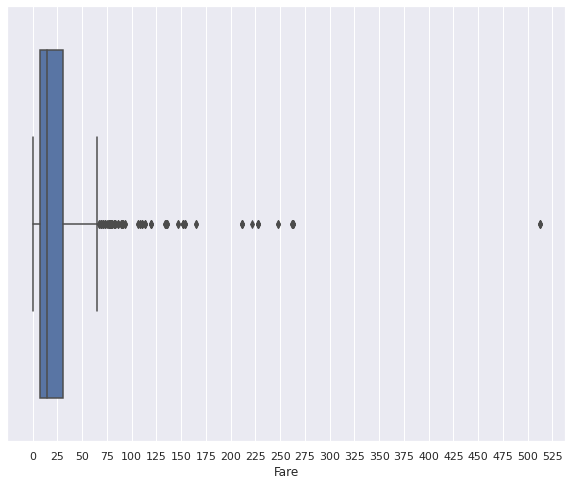

In [211]:
# Investigate the fare column
sns.boxplot(titanicdt.Fare)
plt.xticks(ticks=np.arange(0, 550, 25));

Passengers who paid roughly above 68 are considered outliers, however according to this [article](https://autumnmccordckp.weebly.com/tickets-and-accomodations.html) higher priced tickets were available. 

## Exploratory Data Analysis

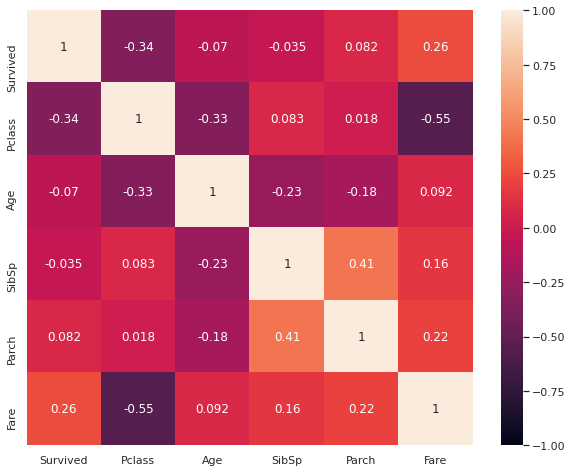

In [212]:
# Determine correlation between features
sns.heatmap(titanicdt.corr(), vmin=-1, vmax=1, annot=True)

As expected there is a strong negative correlation between passenger class and fare. Passengers of upper and middle classes have higher price tickets.

In [213]:
# Relationship between passengers survival and place they embarked
pd.crosstab(titanicdt.Survived, titanicdt.Embarked)

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,219


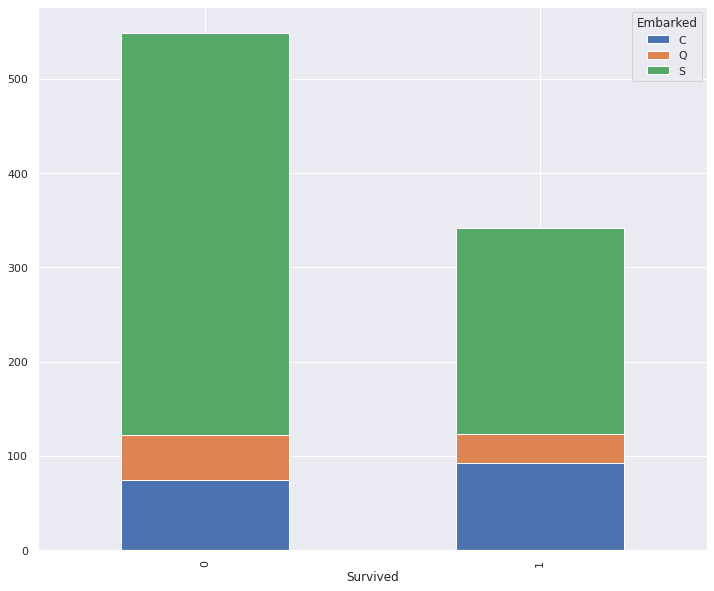

In [214]:
pd.crosstab(titanicdt.Survived, titanicdt.Embarked).plot(kind='bar',stacked=True, figsize=(12,10))

A larger percentage of passengers from Cherbourg survived as opposed to passengers from Southamption and Queenstown.

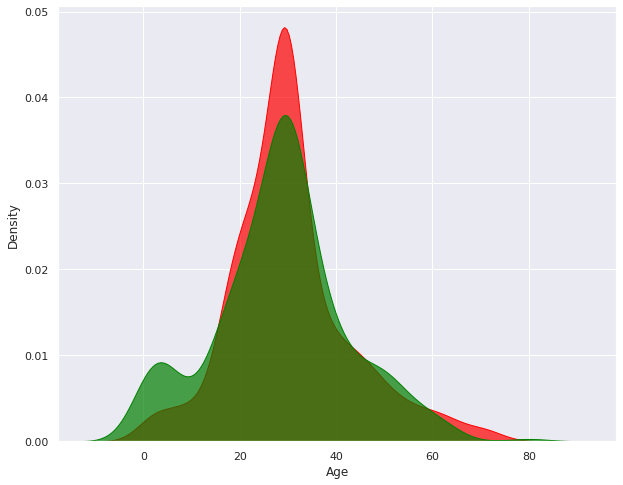

In [215]:
# Age distribution among passengers who perished and those who survived.
sns.kdeplot(titanicdt.loc[titanicdt.Survived == 0, 'Age'], shade=True, color="red", label="Perished", alpha=.7)
sns.kdeplot(titanicdt.loc[titanicdt.Survived == 1, 'Age'], shade=True, color="green", label="Survived", alpha=.7)

Age distributions between passengers who survived and those who didn't are pretty similar. However a larger percentage of younger passengers survived.

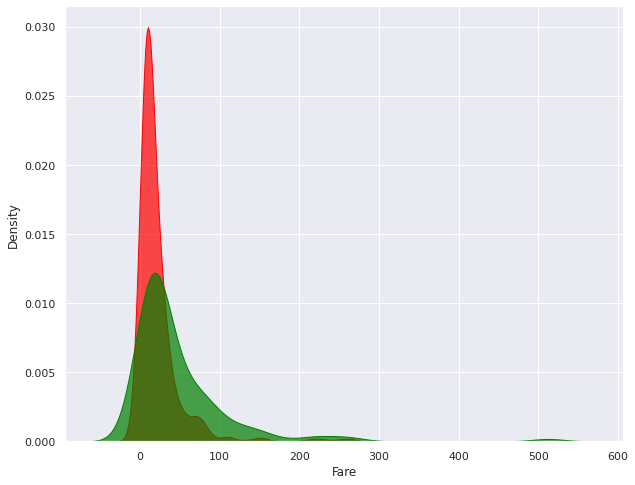

In [216]:
# Fare distribution among passengers who perished and those who survived.
sns.kdeplot(titanicdt.loc[titanicdt.Survived == 0, 'Fare'], shade=True, color="red", label="Perished", alpha=.7)
sns.kdeplot(titanicdt.loc[titanicdt.Survived == 1, 'Fare'], shade=True, color="green", label="Survived", alpha=.7)

Passengers who perished are constricted mostly to fare prices between 0 and 100, most of the passengers who paid higher fares survived. 

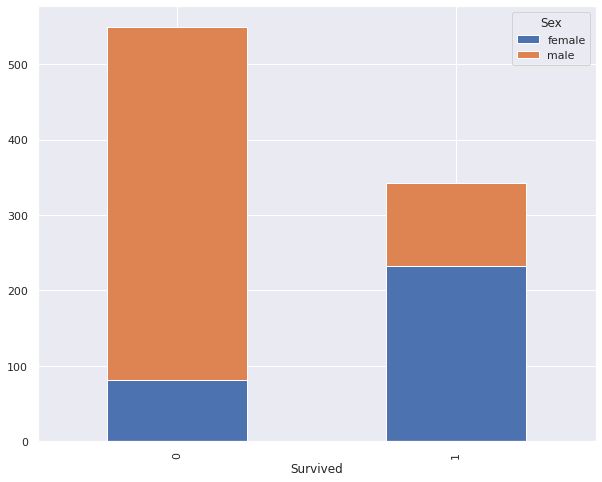

In [217]:
# Relationship between passengers survival and gender
pd.crosstab(titanicdt.Survived, titanicdt['Sex']).plot(kind='bar', stacked=True)

More females survived while more males perished.

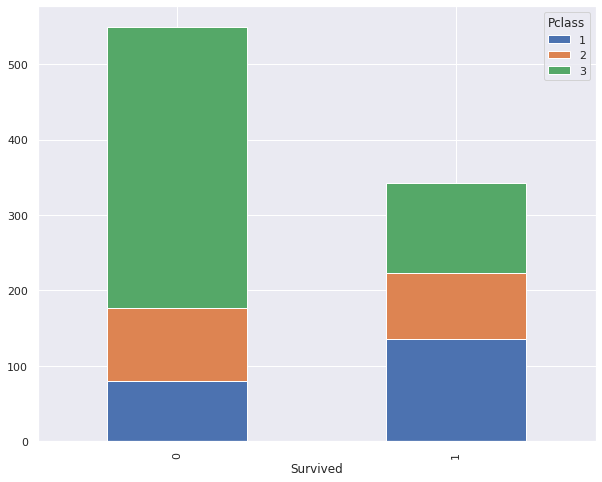

In [218]:
# Relationship between passengers survival and passenger class
pd.crosstab(titanicdt.Survived, titanicdt['Pclass']).plot(kind='bar', stacked=True)

A larger propotion of lower class passengers perished while a larger proportion of upper class passengers survived.

In [219]:
# Relationship between passengers survival and parch feature
pd.crosstab(titanicdt.Survived, titanicdt['Parch'])

Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,445,53,40,2,4,4,1
1,233,65,40,3,0,1,0


In [220]:
# Distribution of target variable
titanicdt.Survived.value_counts(normalize=True)*100

0    61.616162
1    38.383838
Name: Survived, dtype: float64

The target variable survived is imbalanced  with 61% belong to class 0 and 38% class 1

## Data Modelling

In [221]:
# Encode sex and embarked features
titanicdt['Sex'] = titanicdt.Sex.map({'male':0, 'female':1})
titanicdt['Embarked'] = titanicdt.Embarked.map({'C':0,'S':1,'Q':2})

In [222]:
# Split data into train and test sets
X = titanicdt.drop(['Survived'],axis=1)
Y = titanicdt['Survived']

# Stratify Y variable
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.3, random_state=23, stratify = Y)

In [223]:
# Perform linear discriminant analysis on data
lda = LinearDiscriminantAnalysis(n_components=2)

lda.fit(x_train, y_train)

lda.explained_variance_ratio_


array([1.])

In [224]:
# The first discriminant explains 100% variance in our data. Attempt to classify survival rate with lda
lda_pred = lda.predict(x_test)
print(classification_report(y_test, lda_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       165
           1       0.77      0.66      0.71       103

    accuracy                           0.79       268
   macro avg       0.79      0.77      0.78       268
weighted avg       0.79      0.79      0.79       268



Our LDA classifier has an overall accuracy of 79%. Recall and precison scores for the Survived class are lower.

In [225]:
# Get the roc_auc_scores due to the imbalance in our classes
print(roc_auc_score(y_test, lda.predict_proba(x_test)[:, 1]))

0.8235069137981759


The LDA classifier has a fairly high roc_auc score: 82% for our positive class.

In [226]:
# Transform train and test features
x_train_lda = lda.transform(x_train)
x_test_lda = lda.transform(x_test)

In [245]:
# Scale x train and x test with a standard scaler
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [235]:
# Create parameter grid and set up grid search
parameters = {
    'n_neighbors': np.arange(5, 11),
    'p':[1,2],
    'weights': ['uniform', 'distance'],
    'leaf_size': np.arange(20, 60, 10),
    'metric': ['euclidean','manhattan'],
    'algorithm': ['kd_tree','ball_tree','brute']
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid=parameters, scoring='roc_auc', cv=10)

In [246]:
# Fit with scaled features and lda features
scaled_features = grid_knn.fit(x_train, y_train)
lda_features = grid_knn.fit(x_train_lda,y_train)

In [247]:
print(f'Scaled X: {scaled_features.best_score_}\nLDA Transformed X: {lda_features.best_score_}')

Scaled X: 0.8359599004478868
LDA Transformed X: 0.8359599004478868


Similar performance between scaled features and lda transformed features.

In [248]:
print(f'Scaled X: {scaled_features.best_params_}\nLDA Transformed X: {lda_features.best_params_}')

Scaled X: {'algorithm': 'kd_tree', 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
LDA Transformed X: {'algorithm': 'kd_tree', 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


In [252]:
knn_lda =  KNeighborsClassifier(n_neighbors=9, algorithm='kd_tree',leaf_size=20, metric='euclidean',p=1).fit(x_train_lda, y_train)
print(classification_report(y_test,knn_lda.predict(x_test_lda)))

              precision    recall  f1-score   support

           0       0.80      0.90      0.84       165
           1       0.79      0.63      0.70       103

    accuracy                           0.79       268
   macro avg       0.79      0.76      0.77       268
weighted avg       0.79      0.79      0.79       268



In [253]:
knn_scaled =  KNeighborsClassifier(n_neighbors=9, algorithm='kd_tree',leaf_size=20, metric='euclidean',p=1).fit(x_train, y_train)
print(classification_report(y_test,knn_scaled.predict(x_test)))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       165
           1       0.79      0.66      0.72       103

    accuracy                           0.80       268
   macro avg       0.80      0.78      0.78       268
weighted avg       0.80      0.80      0.80       268

